# Визуализация данных
Проведём первичную статистику и познакомимся с данными.

## Setup
Оптимизируем дальнейший код и сразу заполним пространство всем необходимым функционалом.

In [1]:
import os
from typing import Literal

import geopandas as gpd
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
def check_folder(name: str) -> str:
    """If folder not exists - create, after return path"""

    if not os.path.exists(name):
        os.makedirs(name)

    return name

In [3]:
FIG_SIZE = (38.4,21.6)  # 3810x2160

SOURCE_PATH = 'data/source'
LIGHT_PATH = 'data/light'
VISUAL_PATH = check_folder('visual')

NATURALEARTH_NAME = 'map.zip'
IMF_NAME = 'imf.csv'

In [4]:
sns.set_theme(palette='winter', font='jost', font_scale=3, rc={'figure.figsize': FIG_SIZE})

## IMF & NaturalEarth
Визуализируем объединённый набор данных IMF и NaturalEarth.

Загрузим в память набор данных NaturalEarth и приведём его в нужный вид:

In [5]:
map_df: gpd.GeoDataFrame = gpd.read_file(f'{SOURCE_PATH}/{NATURALEARTH_NAME}', engine='pyogrio', columns=['GU_A3', 'CONTINENT', 'NAME_LONG'])

map_df.rename(columns=str.lower, inplace=True)
map_df.set_index('gu_a3', inplace=True)
map_df.drop(index='ATA', inplace=True)  # drop Antarctica
map_df.to_crs(epsg=3857, inplace=True)

Загрузим в память набор данных IMF:

In [6]:
imf_df: pd.DataFrame = pd.read_csv(f'{SOURCE_PATH}/{IMF_NAME}').set_index('iso_a3')

Визуализируем набор имеющихся стран - построим карту с распределением уровня доходов по странам.
Для этого объединим полученные наборы данных и отберём наблюдения за 2022 год:

In [7]:
imf_2022: gpd.GeoDataFrame = map_df.join(imf_df[imf_df['year'] == 2022], how='left')
display(imf_2022)

,continent,name_long,geometry,year,label,income,group
gu_a3,,,,,,,
IDN,Asia,Indonesia,"MULTIPOLYGON (((13102705.696 463877.598, 13102...",2022.0,Indonesia,13921.403,Lower-middle income
MYS,Asia,Malaysia,"MULTIPOLYGON (((13102705.696 463877.598, 13101...",2022.0,Malaysia,33132.626,Upper-middle income
CHL,South America,Chile,"MULTIPOLYGON (((-7737827.685 -1979875.500, -77...",2022.0,Chile,25782.864,Upper-middle income
BOL,South America,Bolivia,"POLYGON ((-7737827.685 -1979875.500, -7737828....",2022.0,Bolivia,9611.910,Lower-middle income
PER,South America,Peru,"MULTIPOLYGON (((-7737827.685 -1979875.500, -77...",2022.0,Peru,14124.797,Upper-middle income
...,...,...,...,...,...,...,...
MAC,Asia,Macao,"MULTIPOLYGON (((12641286.013 2531110.377, 1264...",2022.0,Macao SAR,54771.290,High income
ATC,Oceania,Ashmore and Cartier Islands,"POLYGON ((13758756.865 -1394492.973, 13758838....",NaN,NaN,NaN,NaN
BJN,North America,Bajo Nuevo Bank (Petrel Islands),"POLYGON ((-8904366.797 1780988.794, -8904203.7...",NaN,NaN,NaN,NaN


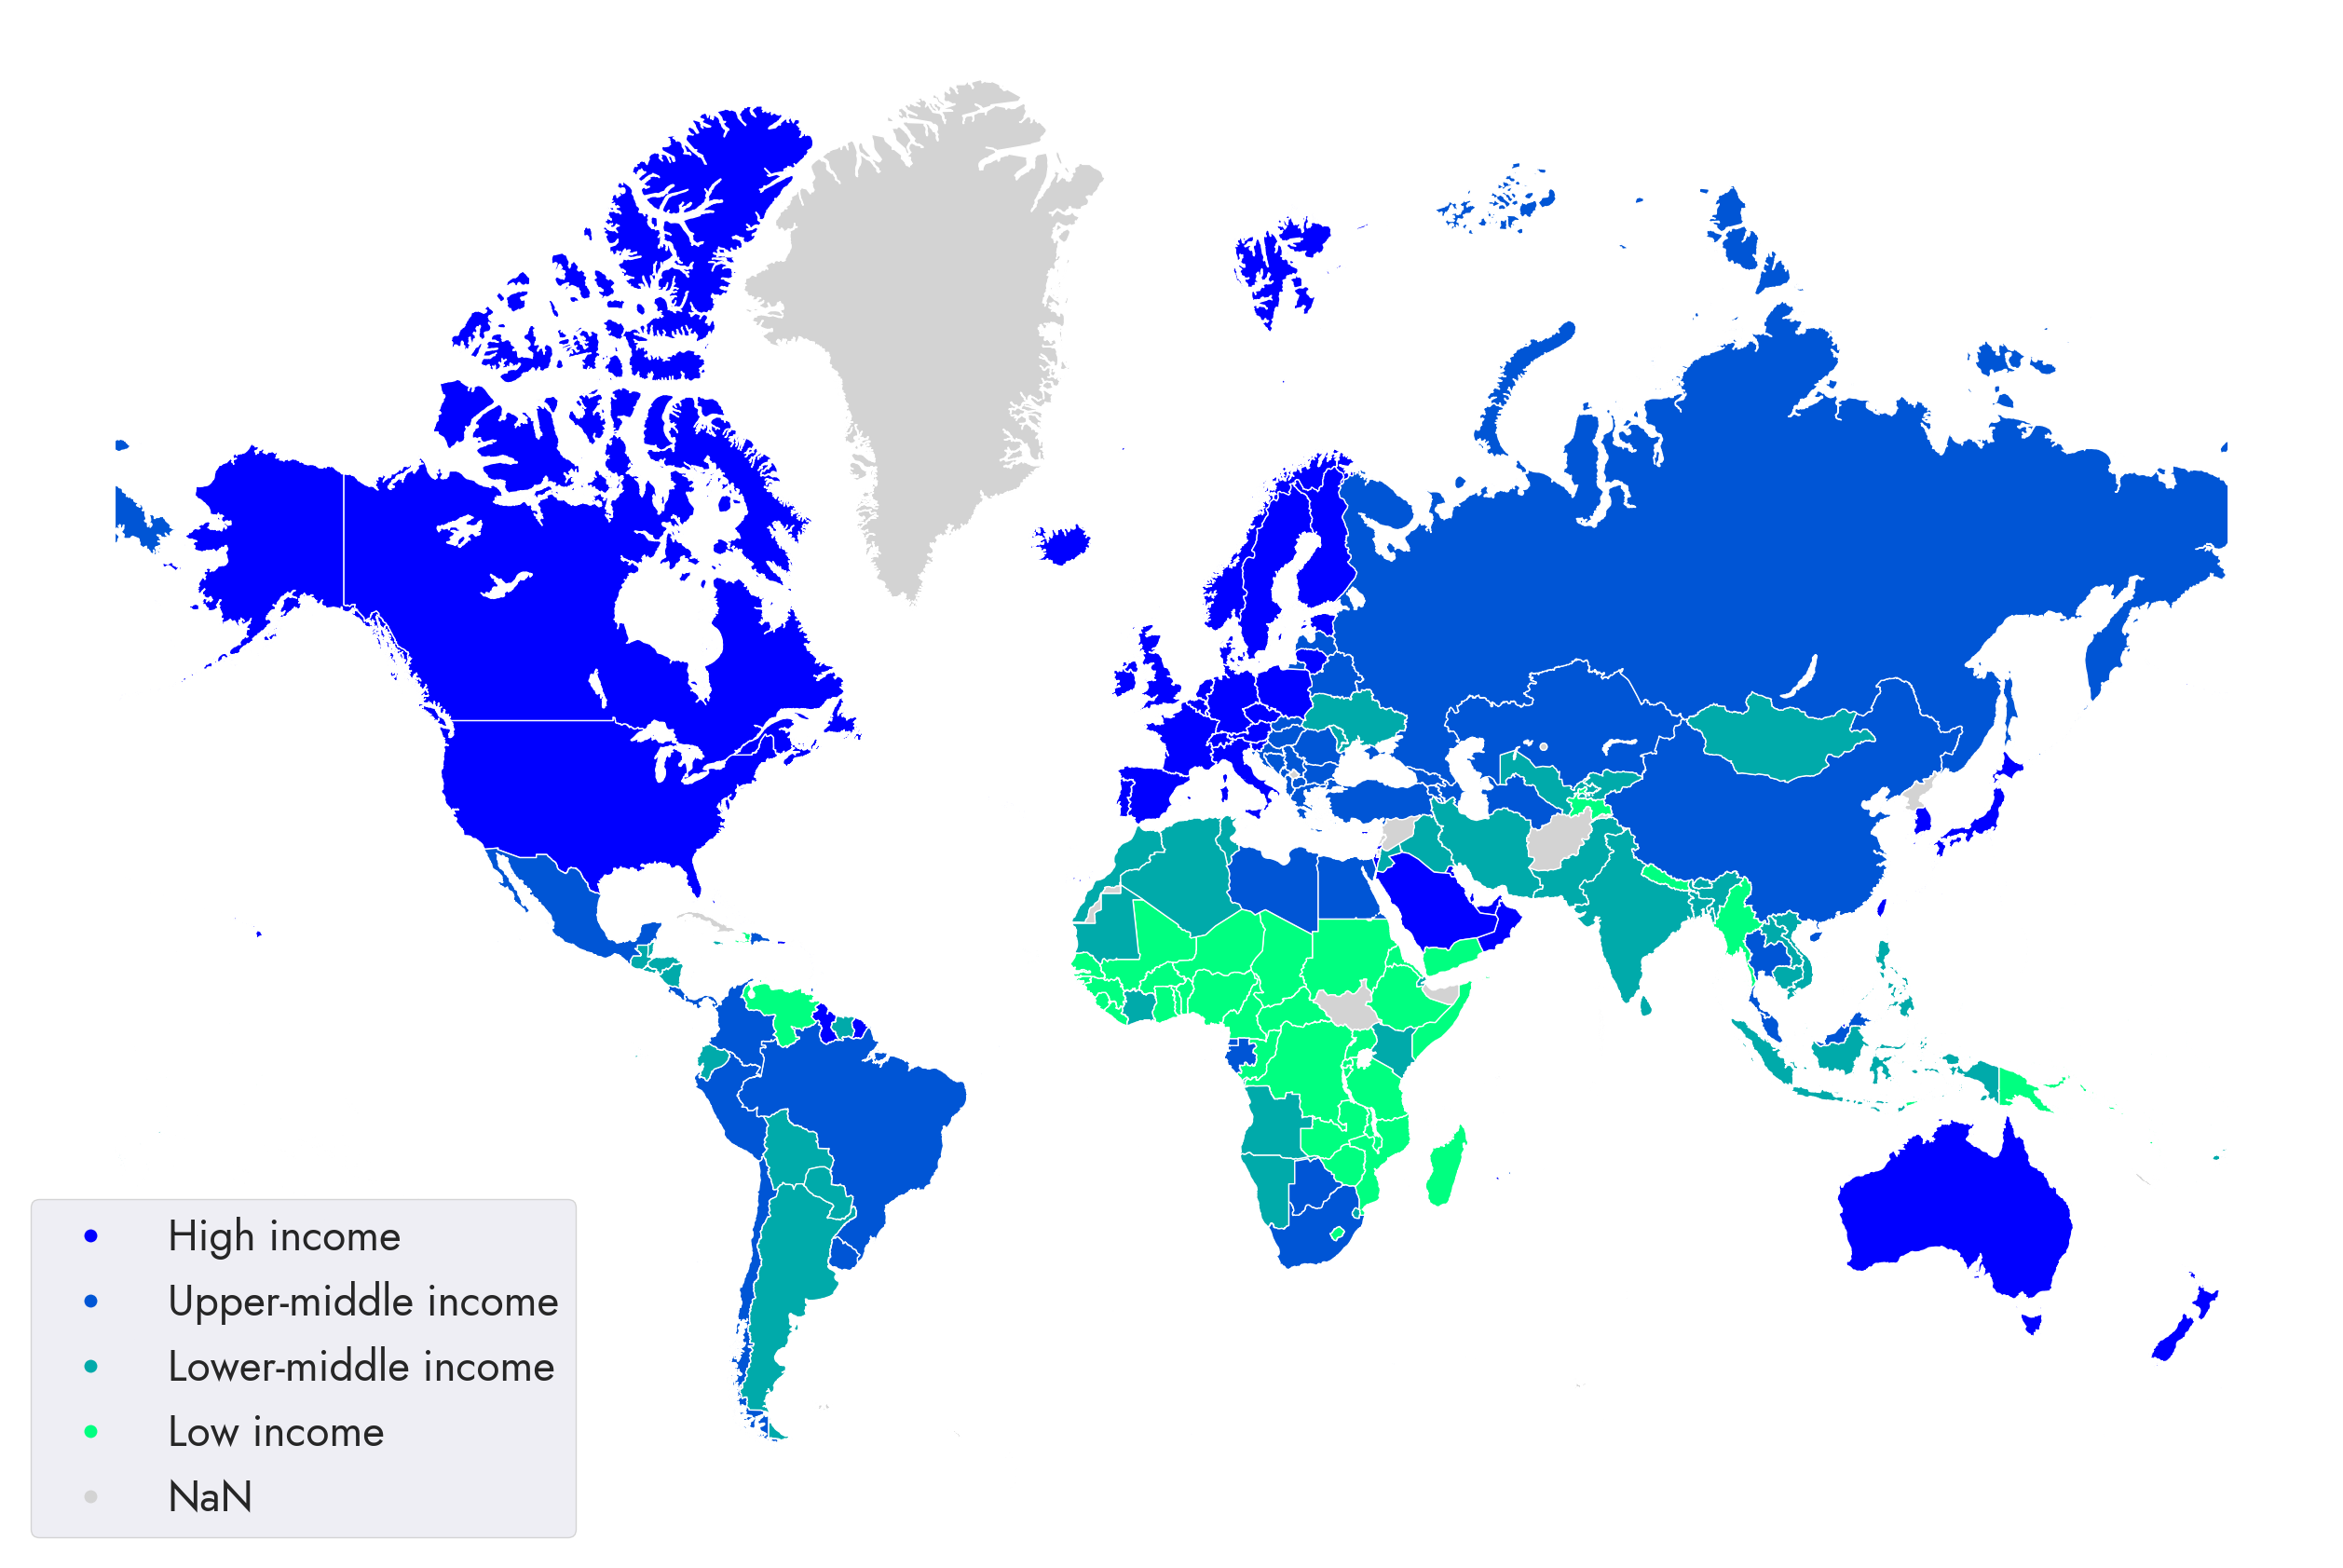

In [8]:
imf_plot_map = imf_2022.plot(column='group', cmap='winter', missing_kwds={'color': 'lightgrey'},
                             legend=True, legend_kwds={'loc': 'lower left'},
                             categories=['High income', 'Upper-middle income', 'Lower-middle income', 'Low income'])
imf_plot_map.set_axis_off();

In [9]:
imf_plot_map.figure.savefig(f'{VISUAL_PATH}/imf_map.png', transparent=True)

Как видно, в выборку не вошли такие страны, как Сирия, Северная Корея, Афганистан, Куба и некоторые другие:

In [10]:
imf_2022[imf_2022['group'].isnull()]['name_long'].unique()

array(['Dhekelia', 'Palestine', 'Lebanon', 'South Sudan', 'Syria',
       'Somaliland', 'Dem. Rep. Korea', 'Western Sahara', 'Saint-Martin',
       'Sint Maarten', 'Kosovo', 'Liechtenstein', 'Monaco', 'Afghanistan',
       'US Naval Base Guantanamo Bay', 'Cuba', 'Brazilian Island',
       'Gibraltar', 'Vatican', 'Northern Cyprus',
       'Cyprus U.N. Buffer Zone', 'Siachen Glacier',
       'Baikonur Cosmodrome', 'Akrotiri', 'Southern Patagonian Ice Field',
       'Bir Tawil', 'Greenland', 'New Caledonia', 'Curaçao',
       'Turks and Caicos Islands', 'Saint Pierre and Miquelon',
       'Pitcairn Islands', 'French Polynesia',
       'French Southern and Antarctic Lands',
       'United States Minor Outlying Islands', 'Montserrat',
       'United States Virgin Islands', 'Saint-Barthélemy', 'Anguilla',
       'British Virgin Islands', 'Cayman Islands', 'Bermuda',
       'Heard I. and McDonald Islands', 'Saint Helena', 'Jersey',
       'Guernsey', 'Isle of Man', 'Åland Islands', 'Faeroe Is

## Light
Визуализируем облегчённый датасет за 2022 год.

In [5]:
COLUMNS = ['income', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests', 'devices']


def get_year_light(st: Literal['fixed', 'mobile'], y: int) -> gpd.GeoDataFrame:
    """
    Get aggregated by country dataset

    :param st: serial_type
    :param y: year
    :return: GeoDataFrame
    """

    df: gpd.GeoDataFrame = gpd.read_file(f'{LIGHT_PATH}/{st}/{y}_{st}_light', engine='pyogrio')

    df.set_index('iso_a3', inplace=True)
    df.sort_values(by='income', inplace=True)
    df.set_geometry(df.boundary, inplace=True)  # optimize geometry
    df.to_crs(epsg=3857, inplace=True)

    display(df)

    return df

#### fixed
Визуализируем датасет фиксированной широкополосной сети.

In [6]:
fixed_2022 = get_year_light('fixed', 2022)

,label,income,group,continent,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry
iso_a3,,,,,,,,,,
BDI,Burundi,676.002,Low income,Africa,7270.000000,6766.000,23.75,3543,795,"MULTILINESTRING ((3265389.848 -420097.907, 326..."
ZWE,Zimbabwe,733.842,Low income,Africa,5375.000000,2687.000,40.00,26336,7078,"MULTILINESTRING ((3127191.701 -2435589.469, 31..."
CAF,Central African Republic,1001.102,Low income,Africa,2492.500000,860.000,769.00,171,46,"MULTILINESTRING ((2064411.260 487362.492, 2064..."
COD,"Congo, Dem. Rep. of the",1227.934,Low income,Africa,9994.000000,3348.750,72.00,7414,2505,"MULTILINESTRING ((1497554.258 -650020.489, 149..."
SOM,Somalia,1247.311,Low income,Africa,4274.000000,4394.250,40.50,9769,2969,"MULTILINESTRING ((4726865.829 -42804.736, 4726..."
...,...,...,...,...,...,...,...,...,...,...
CHE,Switzerland,82274.856,High income,Europe,132038.333333,55715.250,9.50,1466321,487125,"MULTILINESTRING ((674480.338 5803710.684, 6738..."
QAT,Qatar,108635.329,High income,Asia,120882.500000,66901.375,5.00,481555,148771,"MULTILINESTRING ((5658786.078 2843457.452, 565..."
SGP,Singapore,119778.223,High income,Asia,247958.250000,215361.125,5.00,1341188,346677,"MULTILINESTRING ((11542602.767 144924.606, 115..."


In [7]:
fixed_2022.describe().round(2)

,income,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices
count,190.00,190.00,190.00,190.00,190.00,190.00
mean,23919.35,42924.87,23575.74,39.84,2738292.68,763190.54
std,24988.23,47593.74,33502.27,105.21,8086515.32,2280658.99
min,676.00,1532.00,282.00,3.75,25.00,11.00
25%,5136.15,9991.62,4854.56,11.00,21642.25,6677.75
50%,14165.08,22593.25,10798.83,18.00,289214.50,87947.50
75%,37109.78,57277.25,24775.03,25.75,1485266.75,481832.00
max,130002.86,247958.25,215361.12,769.00,78234751.00,23441293.00


Отобразим на карте распределение показателя скорости загрузки по странам:

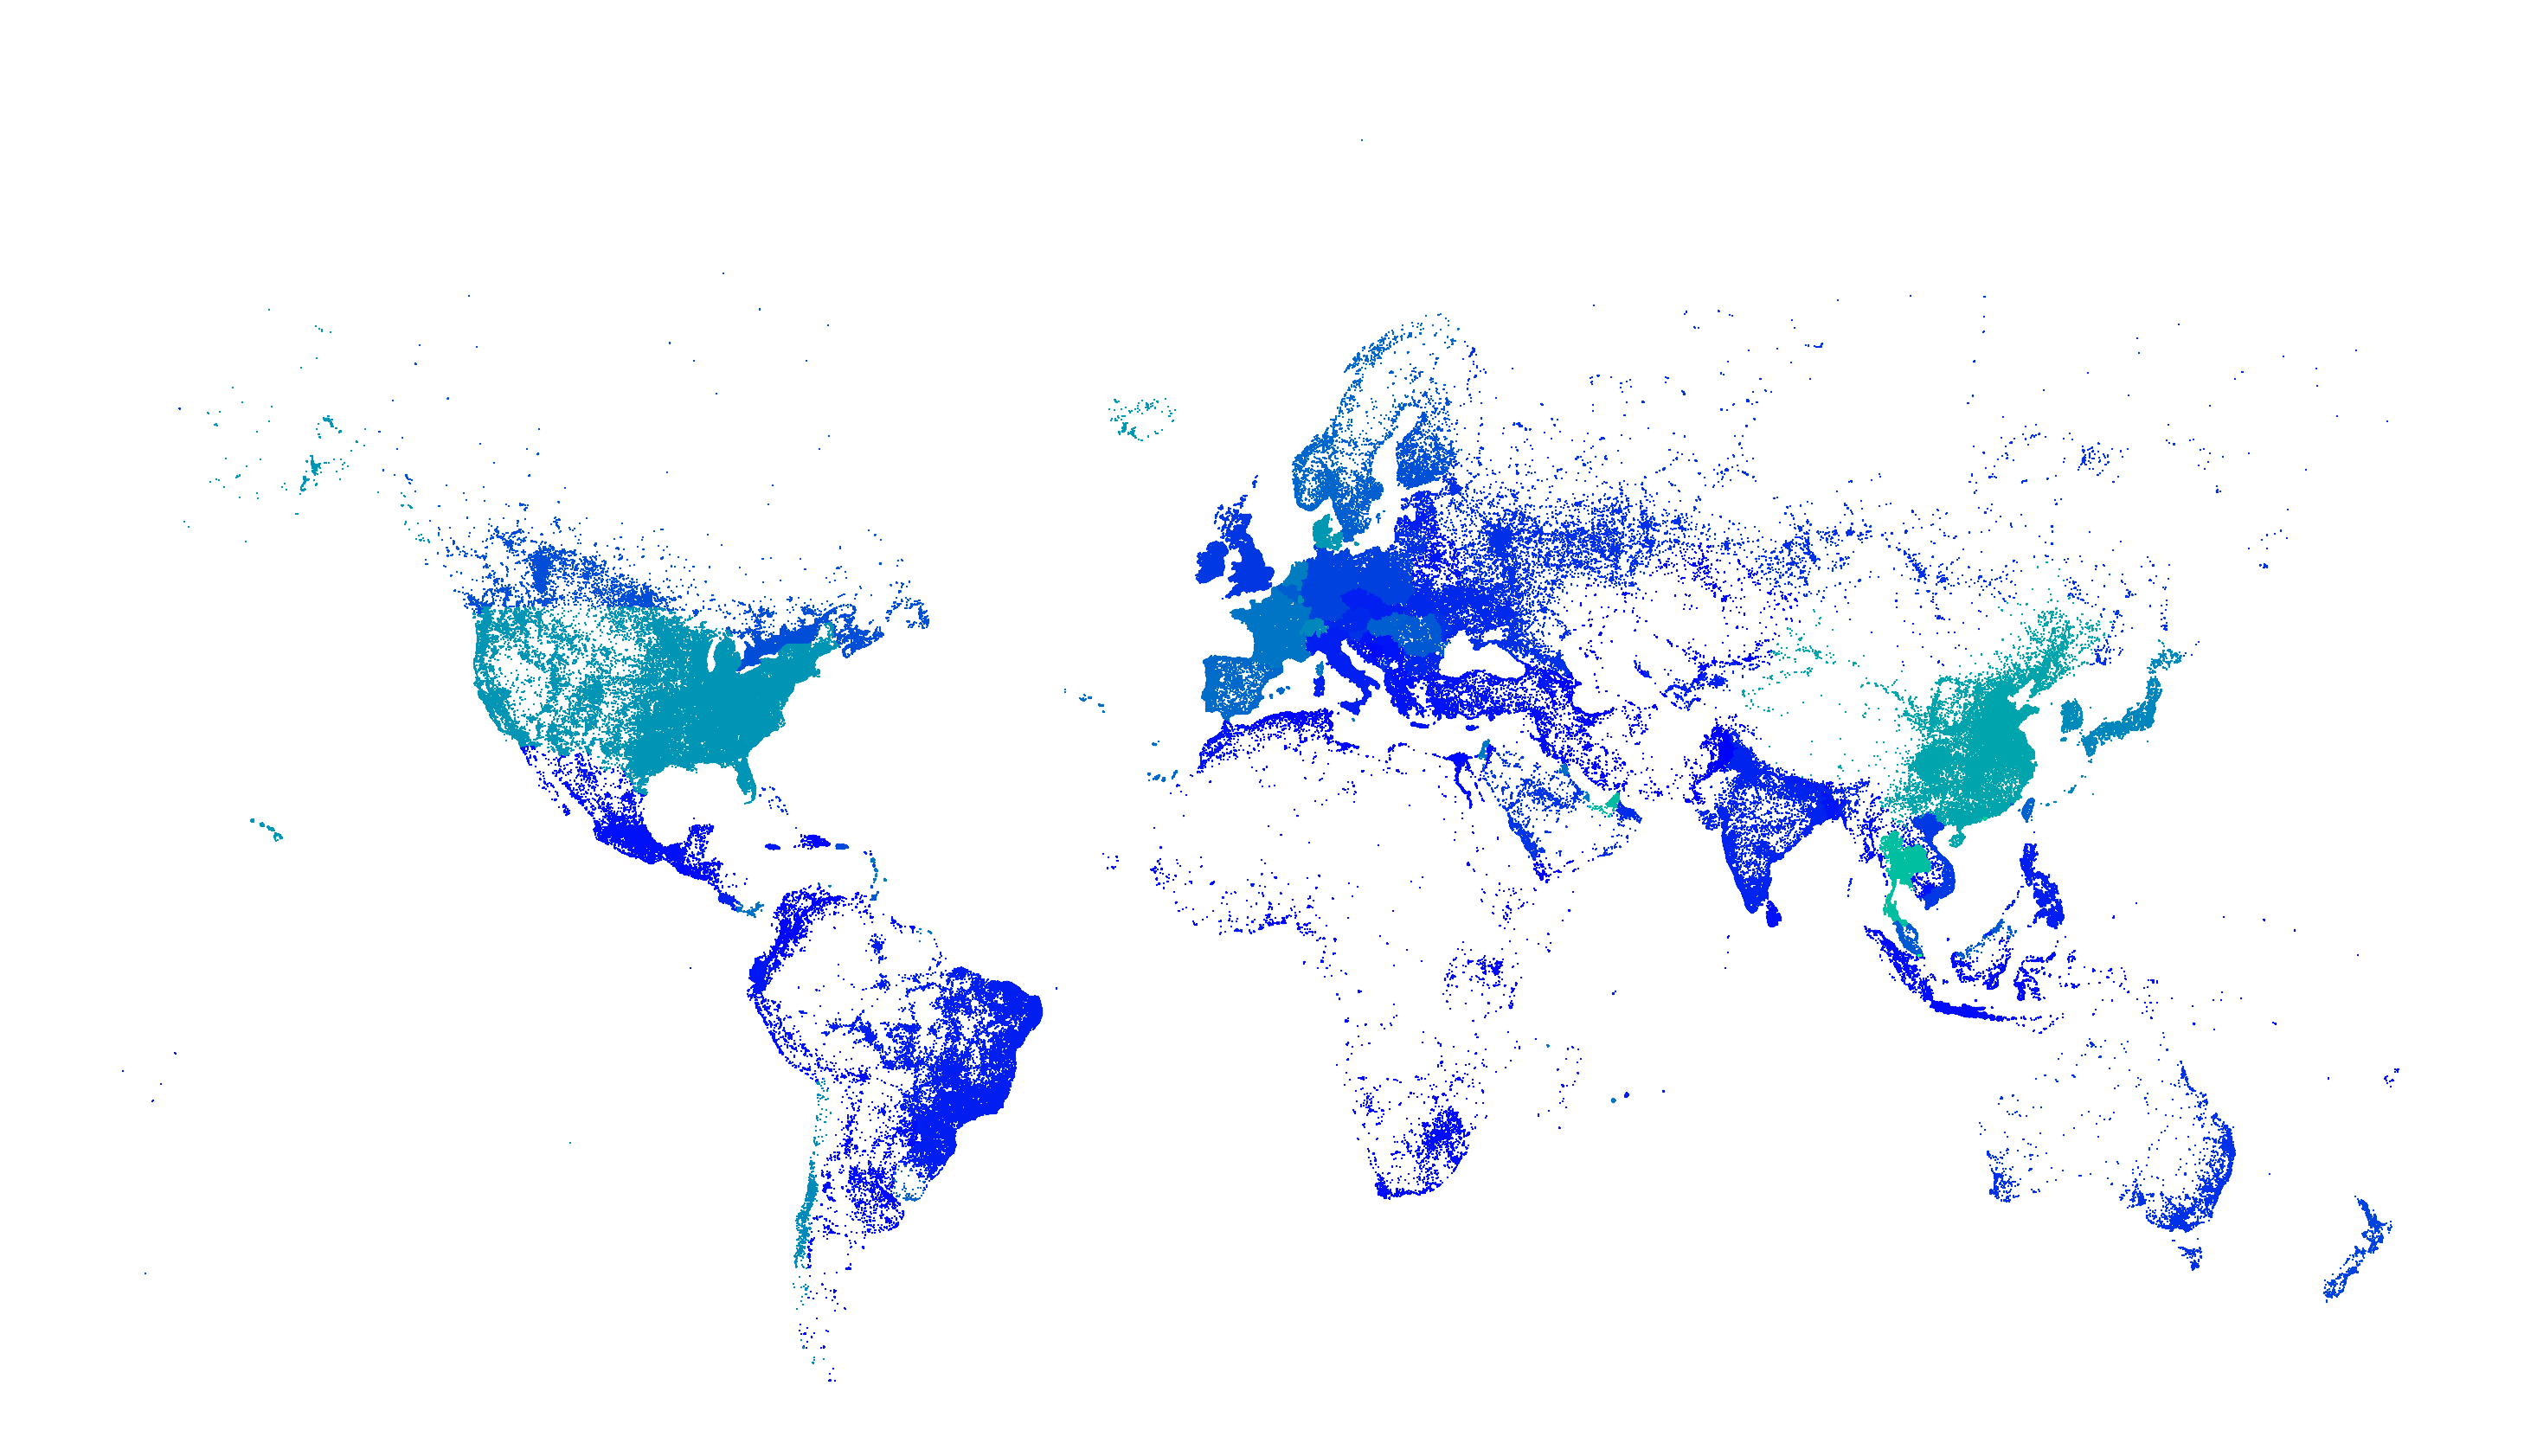

In [8]:
fixed_plot_map = fixed_2022.plot(column='avg_d_kbps', cmap='winter')
fixed_plot_map.set_axis_off();

In [9]:
fixed_plot_map.figure.savefig(f'{VISUAL_PATH}/fixed_map.png', transparent=True)

Построим гистограмму:

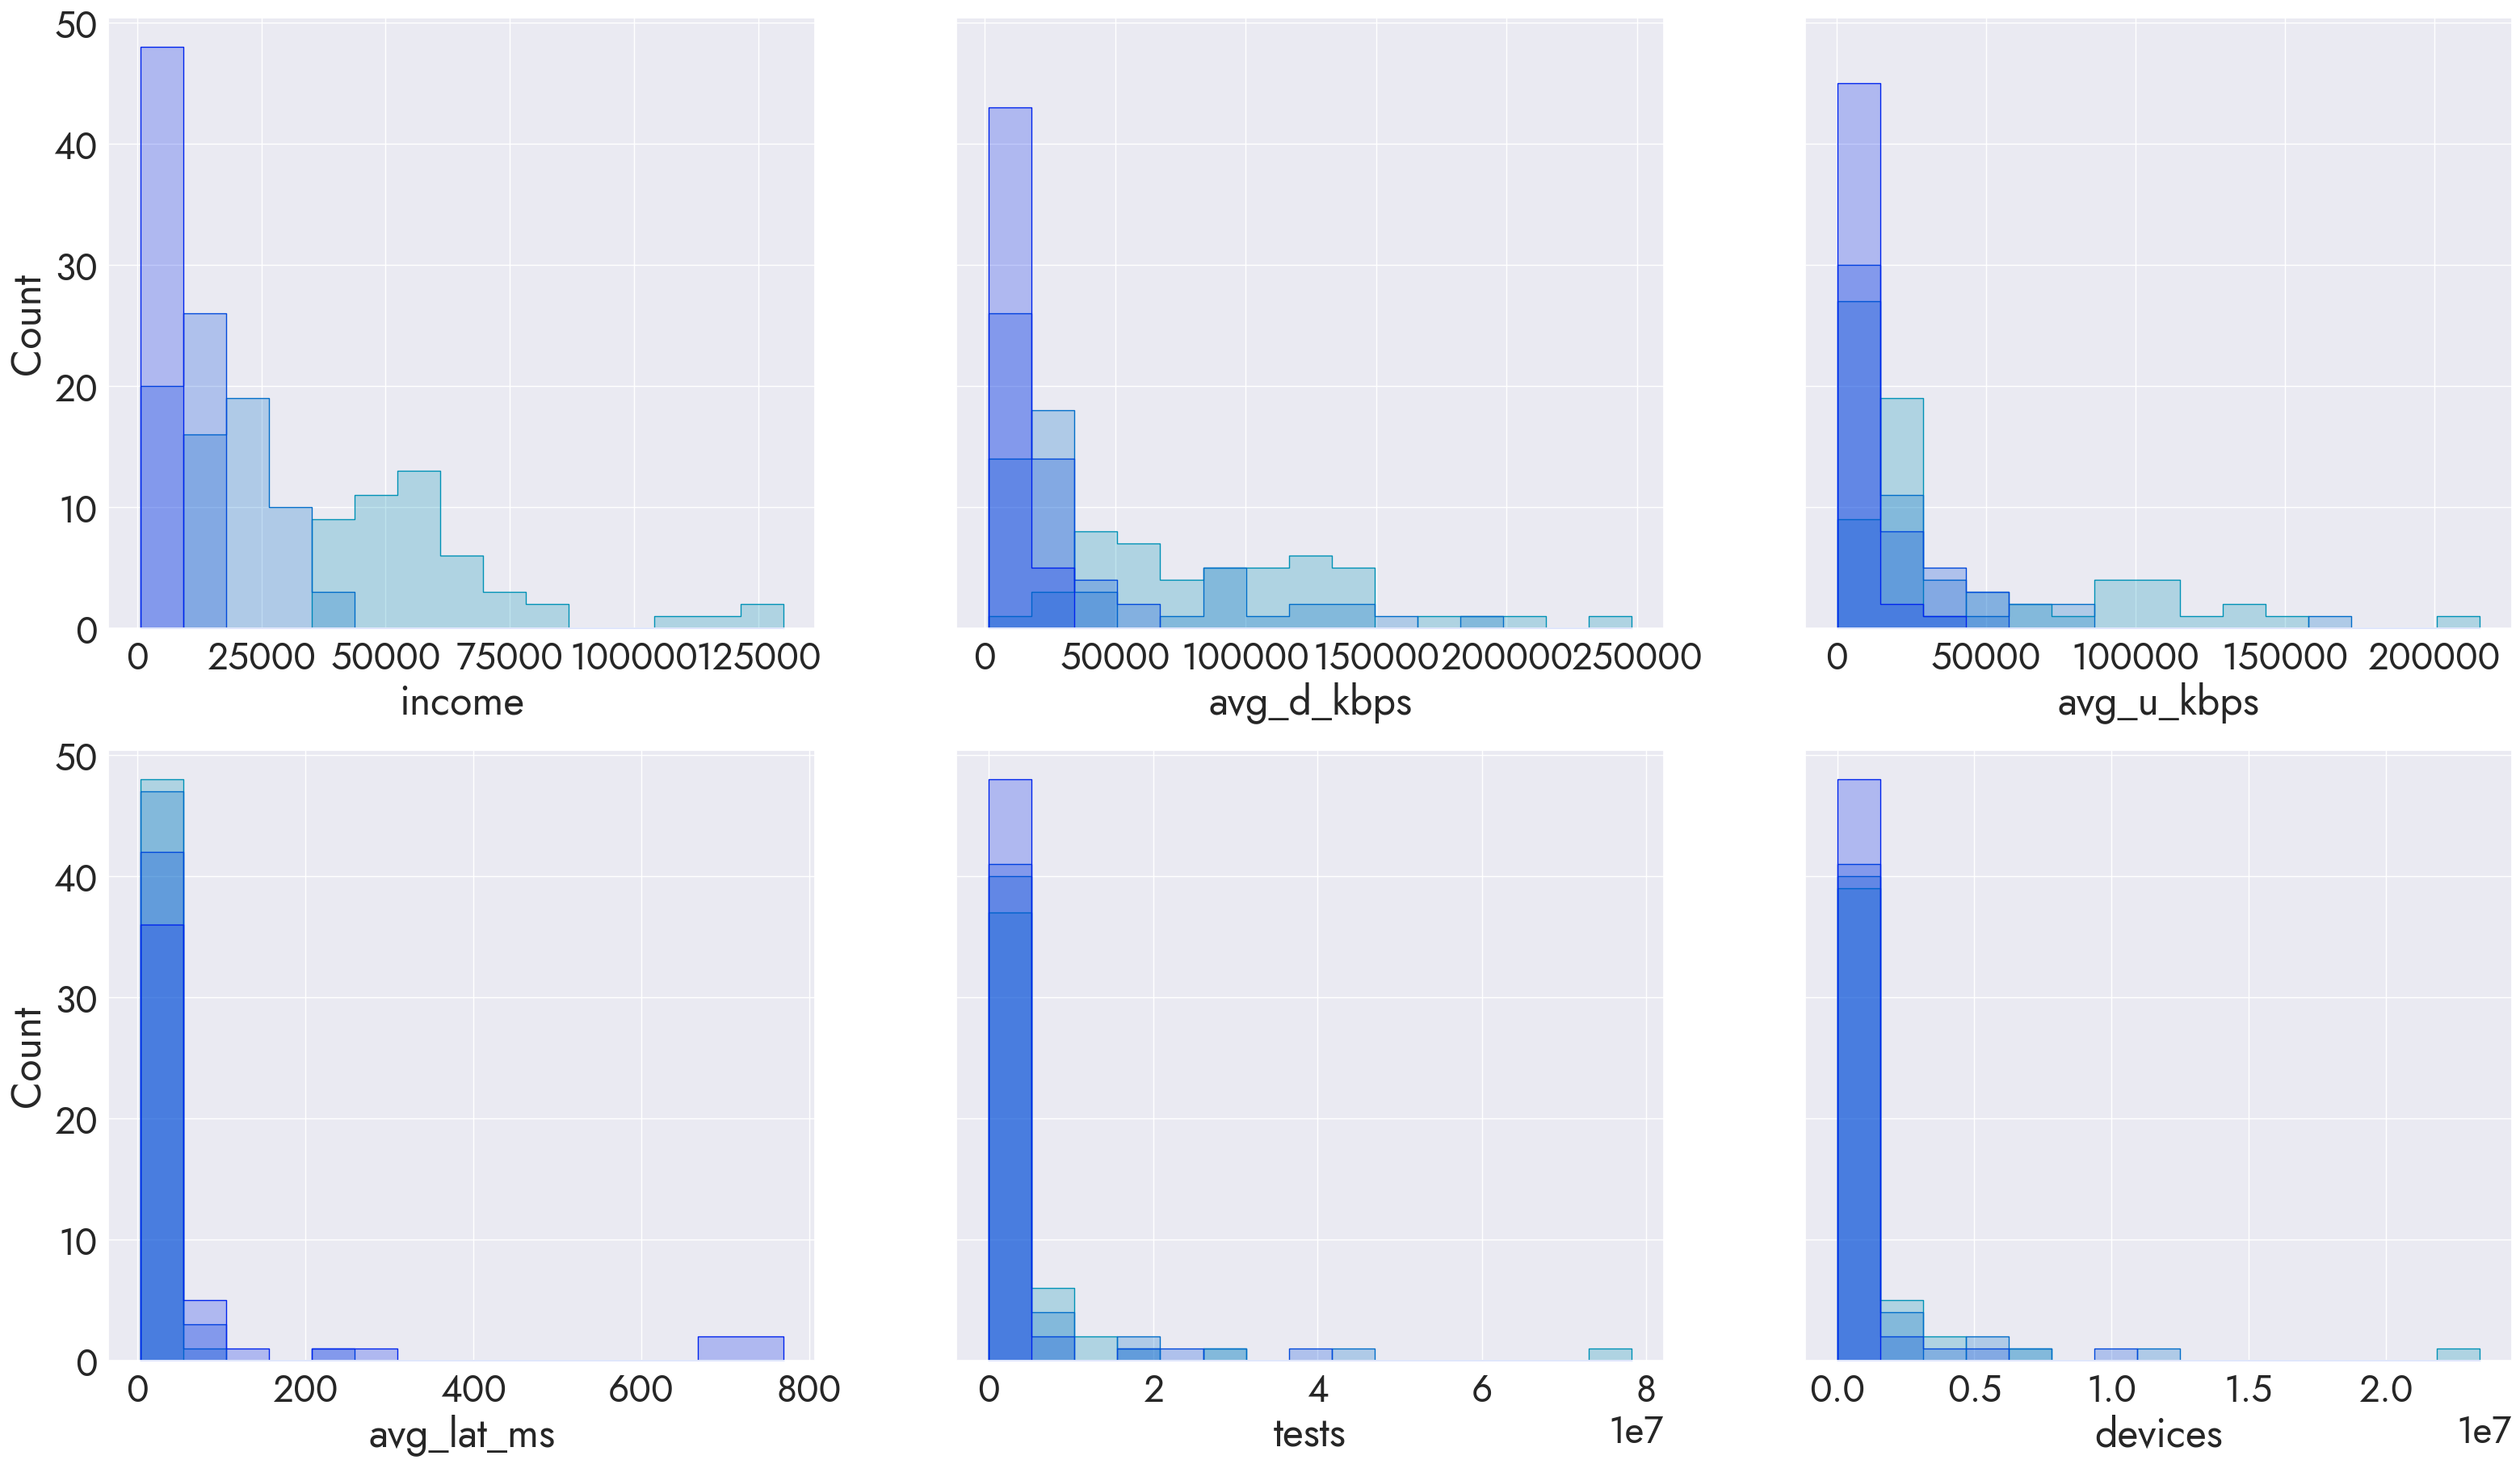

In [10]:
fig, axs = plt.subplots(2, 3, sharey='row')

for column, ax in zip(COLUMNS, axs.flat):
    sns.histplot(data=fixed_2022, x=column, hue='group', element='step', legend=False, bins=15, ax=ax)

In [11]:
fig.savefig(f'{VISUAL_PATH}/fixed_hist.png', transparent=True)

Чтобы вычесть влияние левосторонней асимметрии показателей, логарифмируем их:

In [12]:
for column in COLUMNS:
    fixed_2022[column] = np.log(fixed_2022[column])

Выведем сводную диаграмму для попарного анализа показателей:

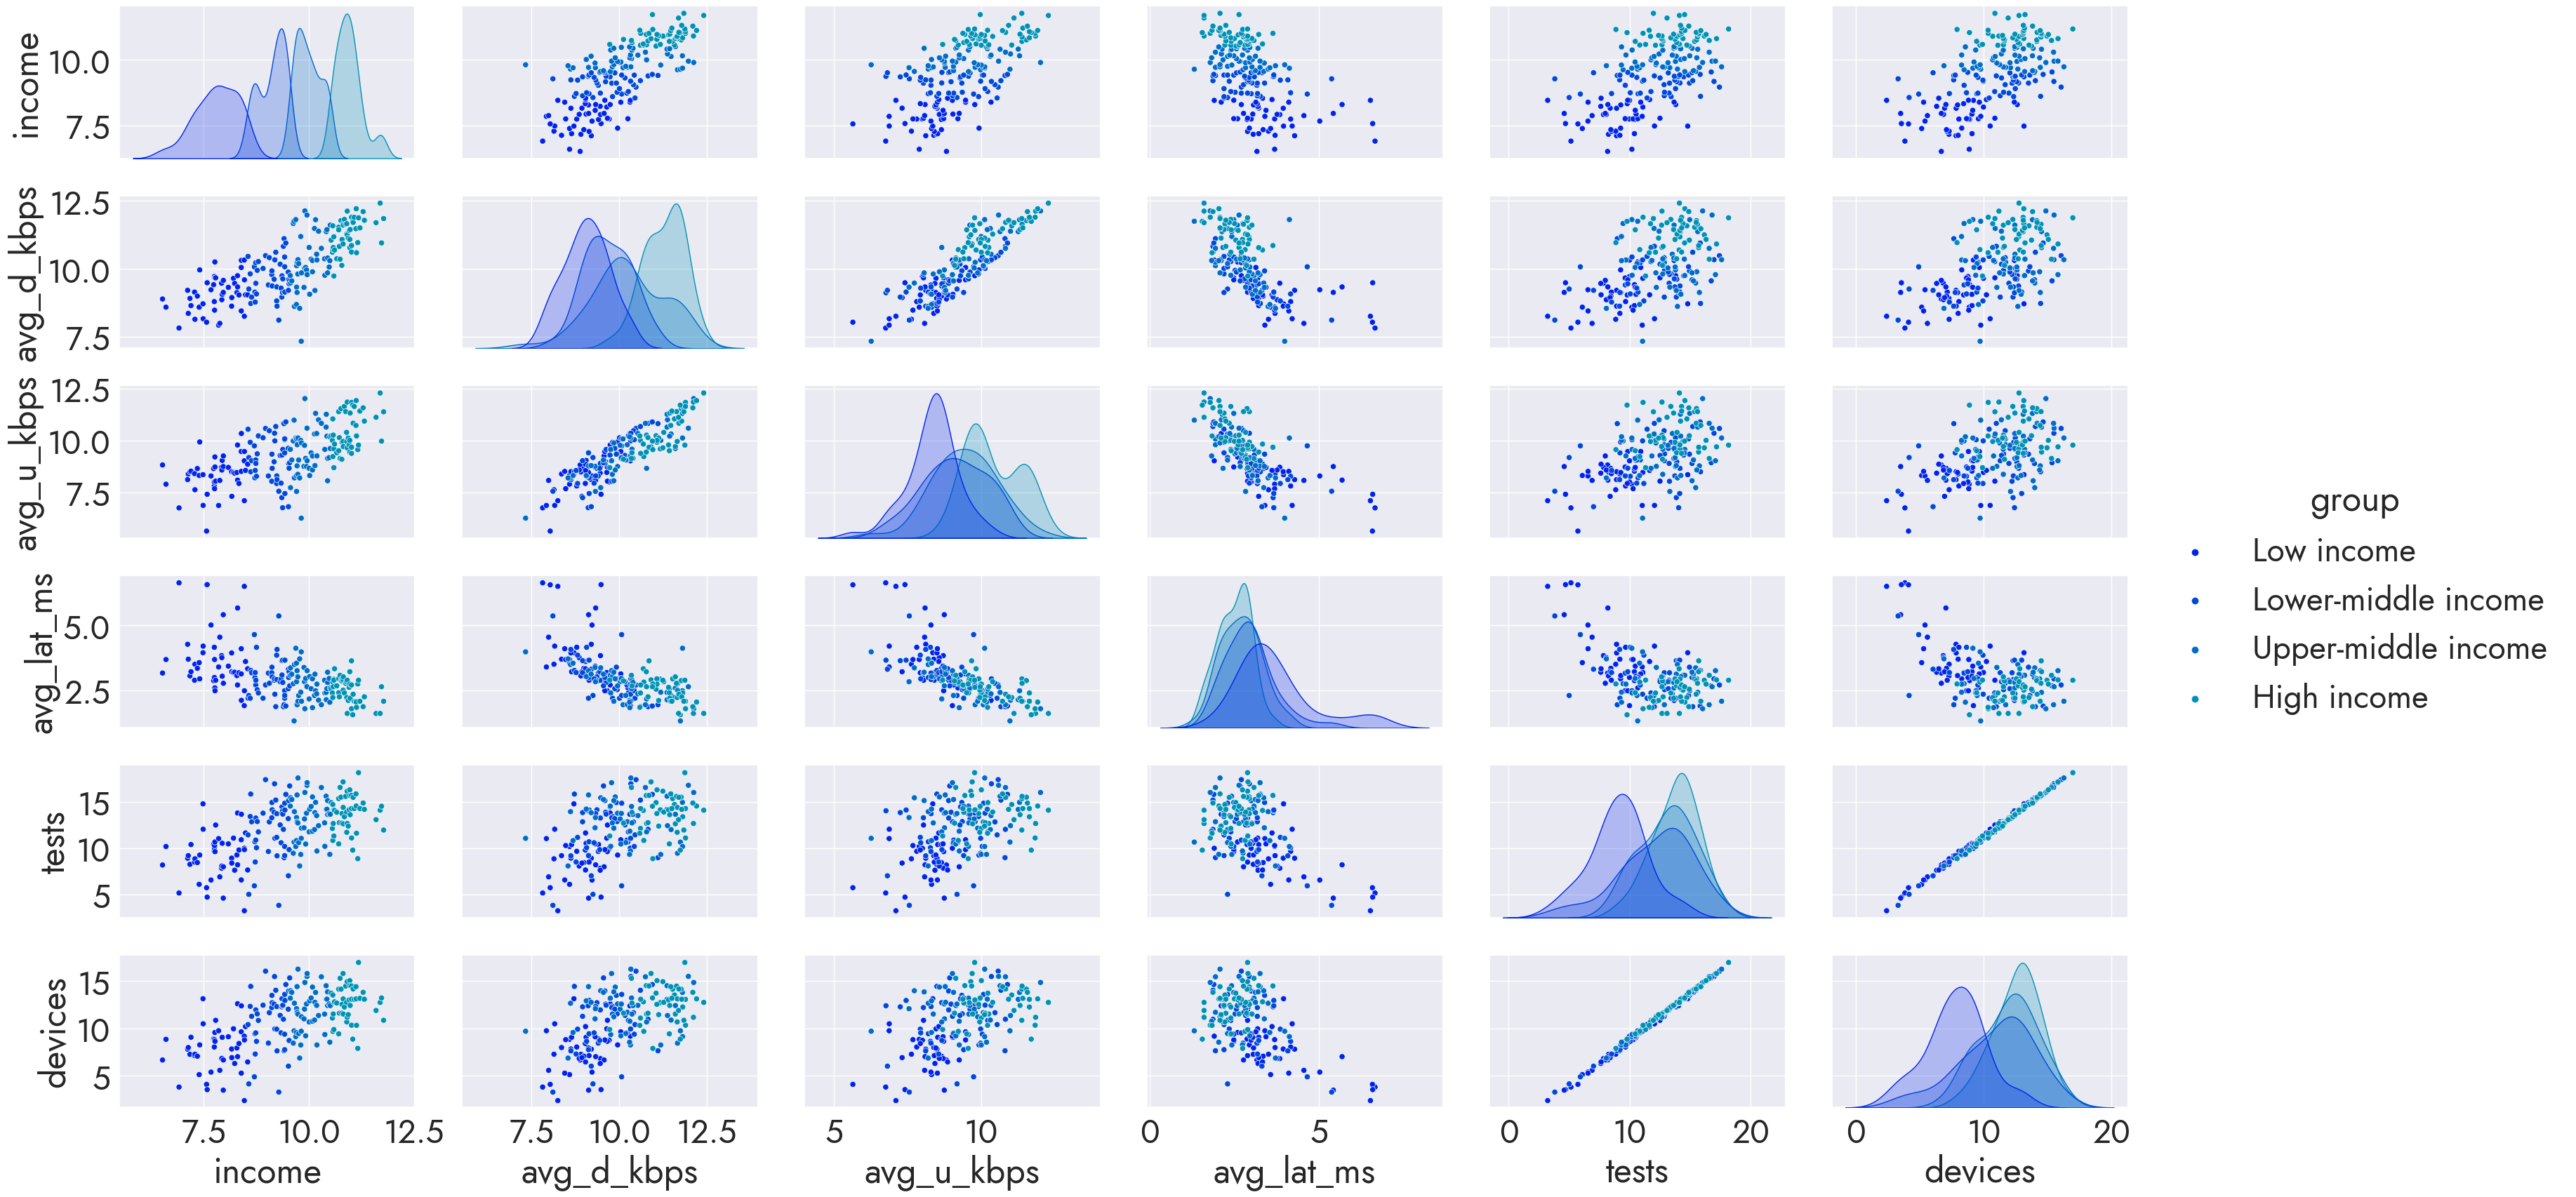

In [13]:
fixed_plot_pair = sns.pairplot(data=fixed_2022, vars=COLUMNS, hue='group',
                               height=FIG_SIZE[0] / 13, aspect=FIG_SIZE[0] / FIG_SIZE[1])

Как видно по сводной диаграмме, между показателями Ookla и IMF наблюдается корреляция - тренд распределения расположен возле диагоналей.
При этом также наблюдается тесная связь между показателями скорости загрузки, скачивания и задержки сети, а также между количеством тестов и устройств. Однако между этими двумя группами показателей корреляция слабая.

In [14]:
fixed_plot_pair.savefig(f'{VISUAL_PATH}/fixed_pair.png', transparent=True)

#### mobile
Визуализируем датасет мобильной широкополосной сети.

In [ ]:
mobile_2022 = get_year_light('mobile', 2022)

In [ ]:
mobile_2022.describe().round(2)

Отобразим на карте распределение показателя скорости загрузки по странам:

In [ ]:
mobile_plot_map = mobile_2022.plot(column='avg_d_kbps', cmap='winter')
mobile_plot_map.set_axis_off();

In [ ]:
mobile_plot_map.figure.savefig(f'{VISUAL_PATH}/mobile_map.png', transparent=True)

Построим гистограмму:

In [ ]:
fig, axs = plt.subplots(2, 3, sharey='row')

for column, ax in zip(COLUMNS, axs.flat):
    sns.histplot(data=mobile_2022, x=column, hue='group', element='step', legend=False, bins=15, ax=ax)

In [ ]:
fig.savefig(f'{VISUAL_PATH}/mobile_hist.png', transparent=True)

Чтобы вычесть влияние левосторонней асимметрии показателей, логарифмируем их:

In [ ]:
for column in COLUMNS:
    mobile_2022[column] = np.log(mobile_2022[column])

Выведем сводную диаграмму для попарного анализа показателей:

In [ ]:
mobile_plot_pair = sns.pairplot(data=mobile_2022, vars=COLUMNS, hue='group', height=FIG_SIZE[0], aspect=FIG_SIZE[0] / FIG_SIZE[1])

Как видно по сводной диаграмме, между показателями Ookla и IMF наблюдается корреляция - тренд распределения расположен возле диагоналей.
При этом также наблюдается тесная связь между показателями скорости загрузки, скачивания и задержки сети, а также между количеством тестов и устройств. Однако между этими двумя группами показателей корреляция слабая.

In [ ]:
mobile_plot_pair.savefig(f'{VISUAL_PATH}/mobile_pair.png', transparent=True)